In [1]:
import os
import random

import tensorflow as tf
from tensorflow import keras

classes = ['normal', 'bp', 'vp']

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(classes),
        values=tf.constant([0, 1, 1]), # normal = 0, pneumonia = 1
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def make_dataset(dir_, num_parallel_calls=tf.data.experimental.AUTOTUNE, shuffle=100, repeat=1, batch=30):
    set_ = []
    
    def preprocess(tensor):
        img_file = tensor[0]
        
        # read the image file
        img_str = tf.io.read_file(img_file)
                
        # decode image as jpeg
        img_decoded = tf.image.decode_jpeg(img_str, channels=3)
                
        # cast image data to float32
        img = tf.cast(img_decoded, tf.float32)
        
        # resize image to proper shape
        resized_img = tf.image.resize(img, (128, 128))
        
        return resized_img / 255., table.lookup(tensor[1])
    
    for class_ in classes:
        curdir = f'{dir_}/{class_}'
        set_.extend([(f'{curdir}/{filename}', class_ ) for filename in os.listdir(curdir) if '.jpe' in filename or '.png' in filename])
        
        # shuffle the (filename, label) tuples
        random.shuffle(set_)
        
    dataset = tf.data.Dataset.from_tensor_slices(tf.stack(set_))
    dataset = dataset.map(preprocess, num_parallel_calls=num_parallel_calls)
    dataset = dataset.shuffle(shuffle).repeat(repeat)
    
    return dataset.batch(batch).prefetch(1)

In [2]:
train_set = make_dataset('train')
val_set = make_dataset('val')
test_set = make_dataset('test')

In [3]:
for item in train_set.take(1):
    print(item[0].shape)
    print(item[1])

(30, 128, 128, 3)
tf.Tensor([1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1], shape=(30,), dtype=int32)


In [4]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(128, 128, 3)),
    keras.layers.Conv2D(64, (3,3), padding='same', activation=keras.activations.relu),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.Conv2D(16, (3,3), padding='same', activation=keras.activations.relu),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        9232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=.001, decay=1e-6),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy'])

history = model.fit(train_set, epochs=25, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')], 
                    validation_data=val_set)

Epoch 1/25
155/155 [==============================] - 66s 427ms/step - loss: 0.2555 - accuracy: 0.8988 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
155/155 [==============================] - 66s 427ms/step - loss: 0.1146 - accuracy: 0.9565 - val_loss: 0.8829 - val_accuracy: 0.6842
Epoch 3/25
155/155 [==============================] - 66s 424ms/step - loss: 0.0895 - accuracy: 0.9658 - val_loss: 0.6303 - val_accuracy: 0.6842
Epoch 4/25
155/155 [==============================] - 65s 421ms/step - loss: 0.0764 - accuracy: 0.9710 - val_loss: 0.7309 - val_accuracy: 0.6842
Epoch 5/25
155/155 [==============================] - 65s 422ms/step - loss: 0.0710 - accuracy: 0.9723 - val_loss: 0.4202 - val_accuracy: 0.7895
Epoch 6/25
155/155 [==============================] - 66s 427ms/step - loss: 0.0707 - accuracy: 0.9730 - val_loss: 0.5672 - val_accuracy: 0.7368
Epoch 7/25
155/155 [==============================] - 66s 426ms/step - loss: 0.0575 - accuracy: 0.9782 - val_loss: 0.4621 

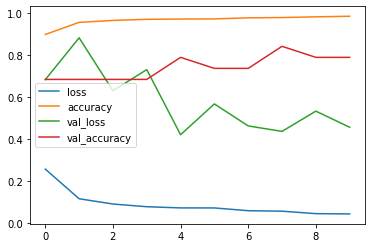

In [7]:
import pandas as pd

pd.DataFrame(history.history).plot()

In [8]:
model.evaluate(test_set)

19/19 [==============================] - 3s 157ms/step - loss: 1.7451 - accuracy: 0.7518


[1.745098772801851, 0.75179857]